In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visual_analogy_single_task(pipeline: Pipeline, train_pairs, test_pair, comp='average'):
    pipeline.model_eval()
    with torch.no_grad():
        Z_few, Z_few_i = [], []

        for input, output in train_pairs:
            input = pipeline.preprocess_and_compress(input)
            output = pipeline.preprocess_and_compress(output)

            z_inp, _ = pipeline.encode(input.unsqueeze(0).to(device))
            z_out, _ = pipeline.encode(output.unsqueeze(0).to(device))
            z_diff = z_out.cpu().numpy().squeeze() - z_inp.cpu().numpy().squeeze()
            Z_few.append(z_diff)
            Z_few_i.append(z_inp.cpu().numpy().squeeze())

        input_q, output_q = test_pair
        input_q = pipeline.preprocess_and_compress(input_q)
        z_query_inp, _ = pipeline.encode(input_q.unsqueeze(0).to(device))
        Z_sol = z_query_inp.cpu().numpy().squeeze()
        Z_sol_o = output_q

        # Compute average rule vector
        z_avg = np.mean(Z_few, axis=0)

        # Find most similar support input to query input (Euclidean)
        Z_euc = [np.linalg.norm(z_i - Z_sol) for z_i in Z_few_i]
        sim_idx = np.argmin(Z_euc)
        z_sim = Z_few[sim_idx]

        # Consistency among support diffs
        Z_cons = cosine_similarity(Z_few)

        # Consistency between average and similarity vector
        Z_rule = np.dot(z_avg, z_sim) / (norm(z_avg) * norm(z_sim))

        # Choose comparison method
        z_comp = z_avg if comp == 'average' else z_sim

        # Apply the transformation to the query input
        z_out = Z_sol + z_comp
        
        out = pipeline.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
        Z_sol_p = pipeline.decompress_and_postprocess(out, Z_sol_o)

    return Z_sol_o, Z_sol_p, Z_cons, Z_rule

In [3]:
import random

from models.convolutional_vae import ConvolutionalVAE, preprocess_grid, postprocess_grid

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalVAE(
        in_channels=10, 
        num_filters=128, 
        latent_dim=128,
        feature_dim=[2, 2]
    ).to(device)

checkpoint = torch.load('../../checkpoints/conv_vae_batchnorm_epoch.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid,
    postprocess_fn=postprocess_grid,
)

In [4]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_60165/2708905769.py:46: RuntimeWarning: invalid value encountered in scalar divide
  Z_rule = np.dot(z_avg, z_sim) / (norm(z_avg) * norm(z_sim))


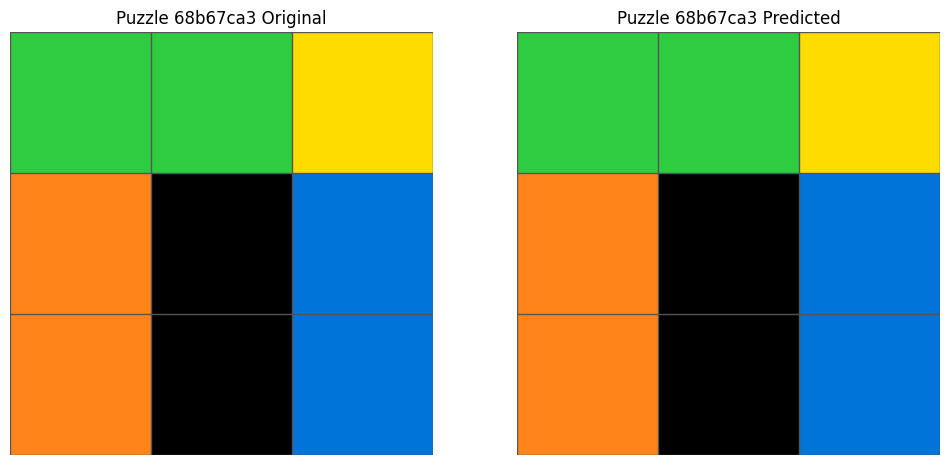

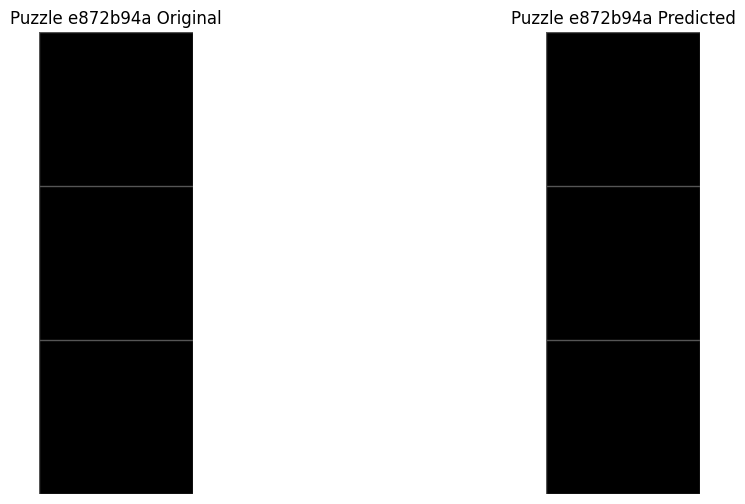

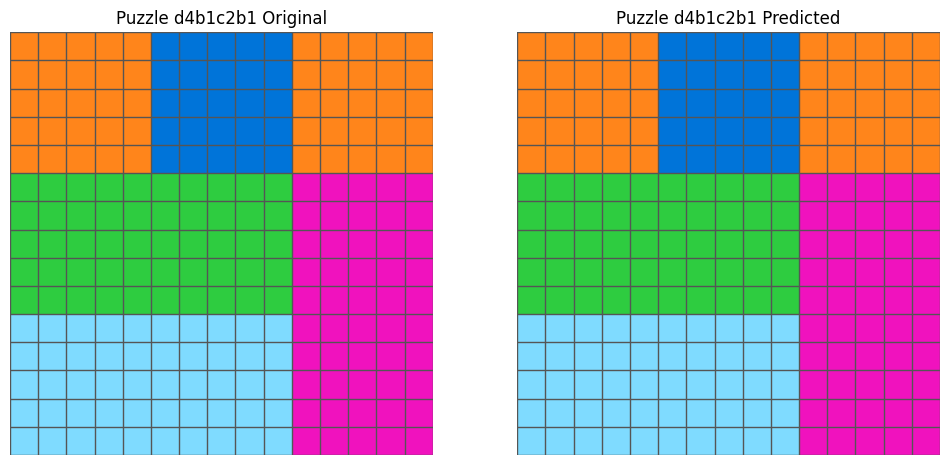

In [7]:
solved_puzzles = []
for puzzle_id, task in data.items():
    Z_sol_o, Z_sol_p, Z_cons, Z_rule = visual_analogy_single_task(
        pipeline=pipeline,
        train_pairs=task['train'],
        test_pair=task['test'][0],
        comp='average'
    )
    if np.array_equal(Z_sol_o, Z_sol_p):
        solved_puzzles.append(puzzle_id)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        draw_grid(axes[0], Z_sol_o, f"Puzzle {puzzle_id} Original")
        draw_grid(axes[1], Z_sol_p, f"Puzzle {puzzle_id} Predicted")
        
     

In [8]:
print(solved_puzzles)

['68b67ca3', 'e872b94a', 'd4b1c2b1']
